In [129]:
import sys
sys.path.append('/home/gridsan/yorlova/Atomistic-Adversarial-Attacks/')
sys.path.append('/home/gridsan/yorlova/NeuralForceField/')
import robust as rb
import torch as ch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import copy
from nff.nn.tensorgrad import compute_grad
from torch.optim import Adam
from torch.utils.data.sampler import RandomSampler
from nff.data import Dataset, split_train_validation_test, collate_dicts, to_tensor
from nff.train import Trainer, get_trainer, get_model, load_model, loss, metrics, evaluate
from nff.train import hooks as nff_hook
from scipy import stats
from nff.io import NeuralFF, AtomsBatch,EnsembleNFF
import plotly.graph_objects as go

In [238]:
def E(z):
    x = z[:, 0]
    y = z[:, 1]
    return 5*x**4 - 20*x**2 + 1.5*x + 10*y**2

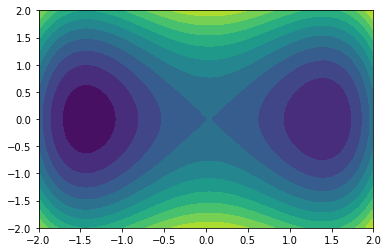

In [239]:
n = 2
x, y = np.linspace(-n, n), np.linspace(-n, n)
z = ch.tensor([[j, i] for i in x for j in y])
energy = E(z).reshape(len(x), len(y))
plt.contourf(x, y, energy, 10)

In [177]:
def F(z):
    return -compute_grad(z, E(z))

In [183]:
z = pos([[1, 1], [2, 2], [3, 3]])
F(z.position)

tensor([[  18.5000,  -25.0000],
        [ -81.5000,  -45.0000],
        [-421.5000,  -65.0000]], grad_fn=<NegBackward>)

In [37]:
z = pos([[1, 1], [2, 2]])
#z_1 = ch.Tensor([[2, 1]])
#z_1.requires_grad = True
print(z.position[0])
print(compute_grad(z.position, E(z.position)))

tensor([1., 1.], grad_fn=<SelectBackward>)
tensor([[-18.5000, -18.5000],
        [ 45.0000,  45.0000]], grad_fn=<AddBackward0>)


In [184]:
def s(z):
    return ch.matmul(z,ch.Tensor([[1],[0]]))

In [98]:
ch.matmul(z.position,ch.Tensor([1,0])).unsqueeze(1)

tensor([[-1.5000],
        [ 1.2999],
        [ 1.4000]], grad_fn=<UnsqueezeBackward0>)

In [185]:
class pos:
    def __init__(self, position):
        self.position = ch.Tensor(position)
        self.position.requires_grad = True
        self.vel = ch.Tensor([[0.0001*(i+1), 0.0001*(i+1)] for i in range(self.position.shape[0])]) #ch.rand(1)
        #x.force=F(x.position)

In [135]:
def nve_bias(z, dt, Vbias_grad, bias = True):
    m = 1000
    st_1 = s(z.position)
    if bias == True:
        force_1 = F(z.position) + Vbias_grad
    else:
        force_1 = F(z.position)
    z.vel=z.vel+0.5*dt*(force_1/m)
    z.position = z.position + z.vel*dt 
    st_2 = s(z.position)
    if bias == True:
        force_2 = F(z.position) + Vbias_grad
    else:
        force_2 = F(z.position)
    #force_2 = F(x.position) - Vbias_grad 
    z.vel = z.vel + 0.5*dt*(force_2)/m

In [136]:
def biasvalue(self, s, st):
    tau = dt*10
    w = 0.4
    sigma = 0.01
    value = 0
    for i in range(st.shape[1]):
        value = value + tau*w*ch.exp(-0.5*(1/sigma**2)*(s - st[:,i].view(-1,1))**2)
    return value
def gradvalue(dt, s, st):
    tau=dt*10
    w=0.4
    sigma=0.01
    gradvalue = 0
    for i in range(st.shape[1]):
        gradvalue = gradvalue - tau*w*((s - st[:,i].view(-1,1))/sigma**2)*ch.exp(-0.5*(1/sigma**2)*(s - st[:,i].view(-1,1))**2)
    return -gradvalue # -compute_grad(s,biasvalue(dt,s,st))

In [189]:
z = pos([[-1.5, 0.1],[1.3, -0.1],[1.4, 0.0]])
s_1 = s(z.position)
z_1 = z.position
temp = 20
j = 0
compute_grad(z.position,s(z.position))[:,0].view(-1, 1)[0]
#compute_grad(s_1, biasvalue(dt,s_1,S).var())[j]*ch.exp(-E(z.position[j])/temp)
dels_2 = (biasvalue(dt,s(z.position)[j],S).var())*compute_grad(z_1, ch.exp(-E(z_1)/temp))
# dels.append(dels_1 + dels_2)    

In [195]:
#compute_grad(z_1, ch.exp(-E(z_1)/temp))
#print(E(z_1))
ch.matmul(compute_grad(z_1, ch.exp(-E(z_1)/temp)), compute_grad(z_1,s(z_1)).transpose(1, 0))[0][0]

tensor(0.8719, grad_fn=<SelectBackward>)

In [218]:
def moveS(z, S, t):
    zeta = 1
    temp = 20
    k = 1
    dels = []
    for j in range(z.position.shape[0]):
        s_1 = s(z.position)
        z_1 = z.position
        dels_1 = compute_grad(s_1, biasvalue(dt,s_1,S).var())[j]*ch.exp(-E(z.position)[j]/temp)
        dels_2 = (biasvalue(dt,s(z.position)[j],S).var())*ch.matmul(compute_grad(z_1, ch.exp(-E(z_1)/temp)), compute_grad(z_1,s(z_1)).transpose(1, 0))[j][j]
        dels.append(dels_1 + dels_2)       
    dels = ch.tensor(dels).view(-1,1)
    delr = (1/compute_grad(z.position,s(z.position))[:,0].view(-1, 1))*dels
    z.position += zeta*ch.exp(ch.tensor(-k*t))*delr

In [128]:
zz=s(z.position)[1]
compute_grad(zz,biasvalue(dt,zz,S).var())

tensor([-1.0286e-20], grad_fn=<ViewBackward>)

In [80]:
S

tensor([[-1.5000],
        [ 1.3000],
        [ 1.4000]])

In [34]:
zz = z.position[:, 0].unsqueeze(1)
zz

tensor([[-1.5000],
        [ 1.3000],
        [ 1.4000]], grad_fn=<UnsqueezeBackward0>)

In [52]:
zz = z.position

compute_grad(s(zz), V(s(zz)))

RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

In [71]:
z.position.view(-1)

tensor([-1.5000e+00,  1.0002e-01,  1.2999e+00, -9.9995e-02,  1.4000e+00,
         3.0000e-05], grad_fn=<ViewBackward>)

In [67]:
zz = z.position[:, 0].unsqueeze(1)
sz = s(z.position)
zzz = z.position

# compute_grad(zz, V(zz))
# compute_grad(z.position[:, 0].unsqueeze(1), V(z.position[:, 0].unsqueeze(1)))
# compute_grad(z.position, V(sz))
compute_grad(s(zzz), 

RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

In [19]:
z = pos([[-1.5, 0.1],[1.3, -0.1],[1.4, 0.0]])
def V(x):
    return x**2

zz = 
s(z.position)
print(V(s(z.position)))
compute_grad(s(z.position), V(s(z.position)))[:,0].view(-1, 1)

tensor([[2.2500],
        [1.6900],
        [1.9600]], grad_fn=<PowBackward0>)


RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

In [16]:
x = np.linspace(-3, 3)
y = np.linspace(-3, 3)
z = ch.Tensor([x, y])
print(s(z))
z.requires_grad=True
#print(len(x))
# fig = go.Figure(data=[go.Surface(z = s(z).numpy(), x=x, y=y)])
# fig.update_layout()
# fig.show()
#plt.plot(z[0], s(z))

tensor([[-3.],
        [-3.]])


In [ ]:
x = ch.linspace(-2, 2)
x.requres_grad = True
plt.plot(x, E(x))
#plt.plot(x.detach().numpy(),F(x).detach().numpy())

In [240]:
z = pos([[-1.5, 0.1],[1.3, -0.1],[1.4, 0.0]])
# z1 = pos([-1.5, 0.1])
# # print(x1.position.detach().numpy())
# z1.position.requires_grad = True
# z2 = pos([1.3, -0.1])
# z2.position.requires_grad = True
# z3 = pos([1.4, 0.0])
# z3.position.requires_grad = True

In [241]:
%%time
#fig, ax = plt.subplots(20, 2, figsize = (10,50))
S = ch.tensor([])
Vb_grad = ch.zeros((z.position.shape[0],1))
y = ch.linspace(-3, 3)
dt = 0.1
Bias = []
zz = []
for i in range(0, 5000):
    if i%20 == 0:
        zz.append(z.position.detach().numpy())
    if i % 10 == 0:
        S = ch.cat((S,s(z.position).detach()),dim=-1)
        Vb_grad = gradvalue(dt,s(z.position), S)
    nve_bias(z, dt, Vb_grad)
    if i%20 == 0:
        Bias.append(biasvalue(dt,y, S).detach())
    if i%10==0:
        moveS(z,S,i*dt)

CPU times: user 1min 6s, sys: 619 ms, total: 1min 6s
Wall time: 1min 6s


In [209]:
S

tensor([[-1.5000],
        [ 1.3000],
        [ 1.4000],
        [-1.4522],
        [ 1.3453],
        [ 1.3977]])

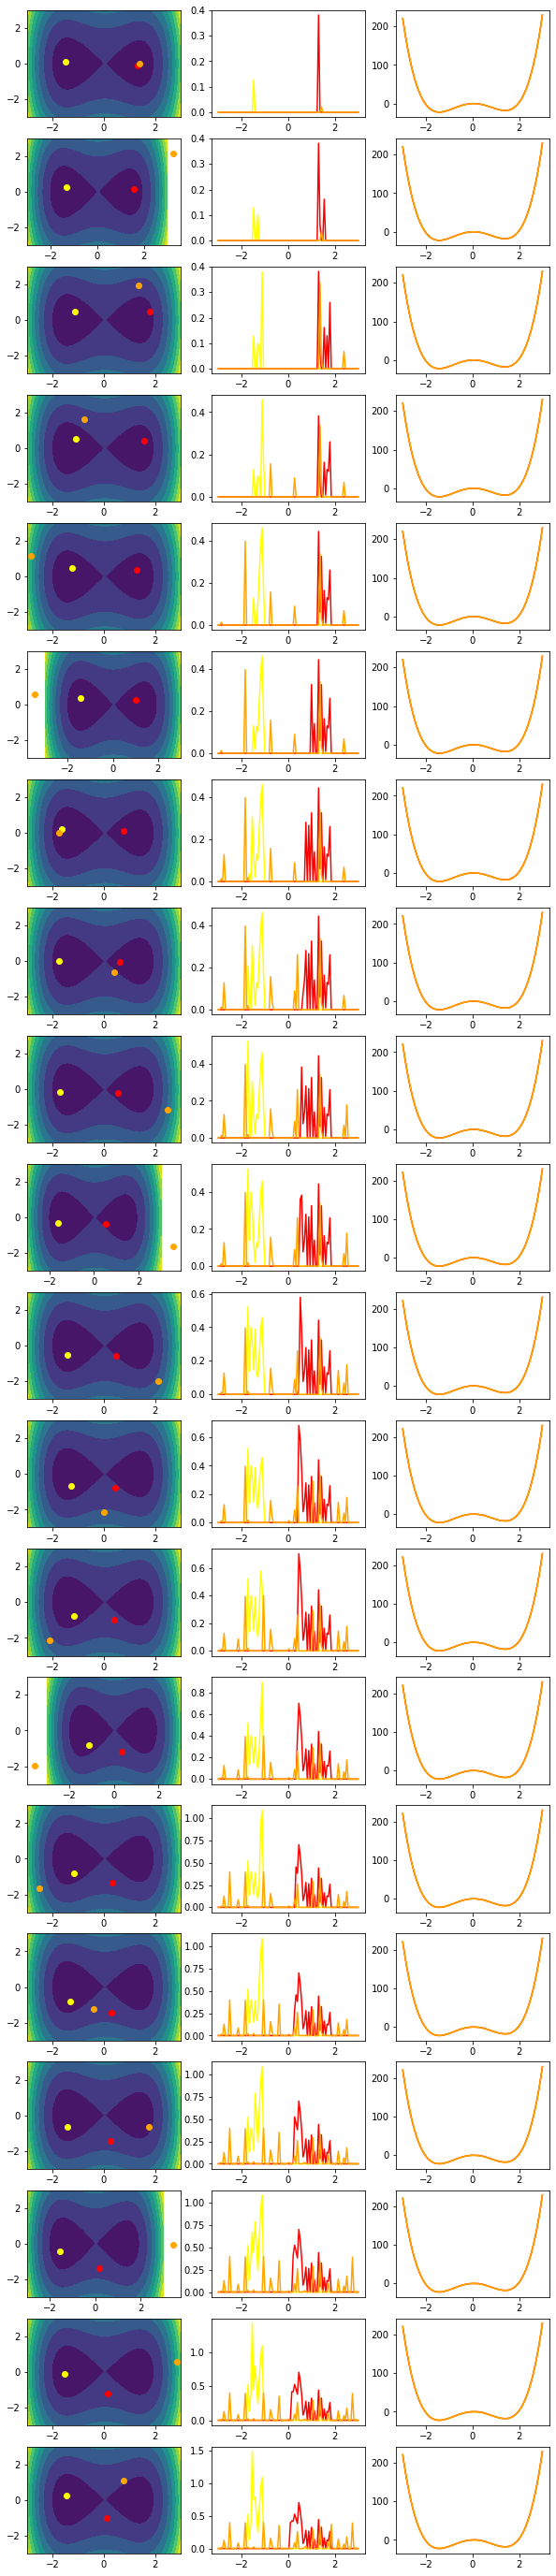

In [242]:
fig, ax = plt.subplots(20, 3, figsize = (10,50))
n = 3
x, y = np.linspace(-n, n, 100), np.linspace(-n, n, 100)
z = ch.tensor([[j, i] for i in x for j in y])
x_1 = ch.linspace(-n, n)
energy = E(z).reshape(len(x), len(y))
energy_1 = [5*x**4 - 20*x**2 + 1.5*x for x in x_1.numpy()]
#print(Bias[0][0])
for k in range(20):
    ax[k][0].contourf(x, y, energy, 10)
    ax[k][0].scatter(zz[k][0][0], zz[k][0][1],color='yellow')
    ax[k][0].scatter(zz[k][1][0], zz[k][1][1],color='red')
    ax[k][0].scatter(zz[k][2][0], zz[k][2][1],color='orange')
    ax[k][1].plot(x_1, Bias[k][0], color='yellow')
    ax[k][1].plot(x_1, Bias[k][1], color='red')
    ax[k][1].plot(x_1, Bias[k][2], color='orange')
    ax[k][2].plot(x_1.numpy(), energy_1 + Bias[k][0].numpy(), color='yellow')
    ax[k][2].plot(x_1.numpy(), energy_1 + Bias[k][1].numpy(), color='red')
    ax[k][2].plot(x_1.numpy(), energy_1 + Bias[k][2].numpy(), color='orange')

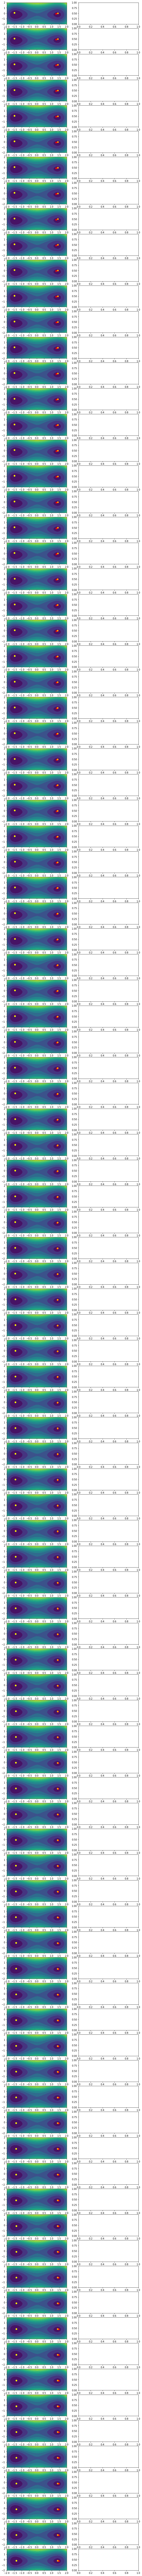

In [88]:
fig, ax = plt.subplots(100, 2, figsize = (10,200))
s1, s2, s3 = [], [], []
k = 0
#y = ch.linspace(-3, 3)
# x, y = np.linspace(-n, n), np.linspace(-n, n)
# z = [[[i, j] for i in x] for j in y]
#print(x1.position)
Vbias1 = bias(0.1)
Vbias2 = bias(0.1)
Vbias3 = bias(0.1)
Vb1, Vb2, Vb3, Vb1_grad, Vb2_grad, Vb3_grad = 0, 0, 0, 0, 0, 0
x, y = np.linspace(-n, n), np.linspace(-n, n)
z = [[[i, j] for i in x] for j in y]
energy = [[E(z[i][j]) for j in range(len(z[i]))] for i in range(len(z))]
for i in range(0, 100):
    if i%1 == 0:
        ax[k][0].contourf(x, y, energy, 10)
        ax[k][0].scatter(z1.position.detach().numpy()[0], z1.position.detach().numpy()[1],color='yellow')
        ax[k][0].scatter(z2.position.detach().numpy()[0], z2.position.detach().numpy()[1],color='red')
        ax[k][0].scatter(z3.position.detach().numpy()[0], z3.position.detach().numpy()[1],color='orange')
    if i % 1 == 0:
        s1.append(s(z1.position.detach().numpy()))
        s2.append(s(z2.position.detach().numpy()))
        s3.append(s(z3.position.detach().numpy()))
        #print(s1)
    nve_bias(z1, 0.1, Vb1_grad)
    nve_bias(z2, 0.1, Vb2_grad)
    nve_bias(z3, 0.1, Vb3_grad)
    k += 1
#     nve(x1, 0.1)
#     nve(x2, 0.1)
#     nve(x3, 0.1)
#     if i%500 == 0:
#         ax[k][1].plot(y, bias(0.1).biasvalue(y, s1), color='purple')
#         ax[k][1].plot(y, bias(0.1).biasvalue(y, s2), color='red')
#         ax[k][1].plot(y, bias(0.1).biasvalue(y, s3), color='green')
#         k += 1
    #print(x1.position)
#     if i % 10 == 0:
#         #print(x1.position)
#         Vb1_grad = bias(0.1).gradvalue(s(x1.position.detach().numpy()), s1)
#         Vb2_grad = bias(0.1).gradvalue(s(x2.position.detach().numpy()), s2)
#         Vb3_grad = bias(0.1).gradvalue(s(x3.position.detach().numpy()), s3)
#         #print(x1.position)